# Task 1: Big Cats
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [125]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install imgaug
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install fuzzy-c-means
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install imblearn

In [126]:
import os

import cv2 as cv
import imgaug.augmenters as iaa
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
plt.rc('axes', axisbelow=True)
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import silhouette_samples, silhouette_score, mutual_info_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN, Birch, KMeans
from sklearn.preprocessing import label_binarize
from fcmeans import FCM
from imblearn.over_sampling import BorderlineSMOTE



In [127]:
RANDOM_STATE=50

In [128]:
data_path = os.path.join("..", "Data-PR-As2", "BigCats")

In [129]:
class_paths = os.listdir(data_path)
imgs = []
labels = []
for class_ in class_paths:
    if class_ != '.DS_Store':
        path = os.path.join(data_path, class_)
        imgs_of_class = os.listdir(path)
        for img in imgs_of_class:
            if img == '.DS_Store':
                imgs_of_class.remove(img)
        imgs += [os.path.join(path, x) for x in imgs_of_class]
        labels += [class_] * len(imgs_of_class)

## Data Analysis

In [130]:
print("# observations:", len(labels))

# observations: 200


In [131]:
classes = list(np.unique(labels))
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

There are 5 classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


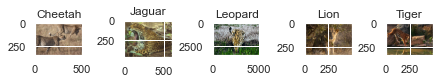

In [132]:
# Visualise one data sample per class
fig, axs = plt.subplots(1, n_classes, constrained_layout=True)
axs = axs.flatten()

for i, class_ in enumerate(classes):
    ob_idx = labels.index(class_)
    with Image.open(imgs[ob_idx]) as img:
        axs[i].imshow(img)
        axs[i].title.set_text(class_)
plt.show()

In [133]:
def plot_class_freq(y):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    if matplotlib.__version__[:3] != "3.3":
        ax.bar_label(ax.containers[0])
    else:
        print("Warning using old version of matplotlib!")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

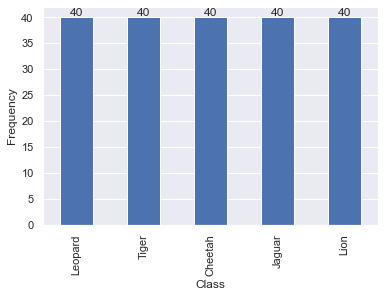

In [134]:
# Check for data imbalance
plot_class_freq(pd.DataFrame(labels))

## Data Augmentation

In [135]:
def aug_data(data, labels, display_idx={}):
    all_imgs = []
    all_labels = []
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.PiecewiseAffine(scale=(0.01, 0.05)),
        iaa.PerspectiveTransform(scale=(0.05, 0.15))
    ])

    for i, x in enumerate(data):
        if '.DS_Store' not in x:
            img = cv.imread(x)
            img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
            aug_img = aug_seq(images=[img])

            all_imgs.append(img)
            all_imgs.append(aug_img[0])
            all_labels.append(labels[i])
            all_labels.append(labels[i])

        if i in display_idx:
            fig, axs = plt.subplots(1, 2, constrained_layout=True)
            axs = axs.flatten()
            axs[0].imshow(img)
            axs[0].title.set_text('Original')
            axs[1].imshow(aug_img[0])
            axs[1].title.set_text('Augmented')
            plt.show()

    return all_imgs, all_labels

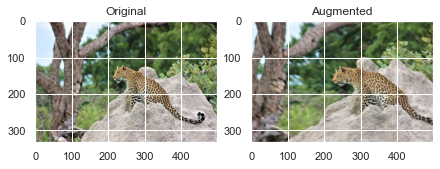

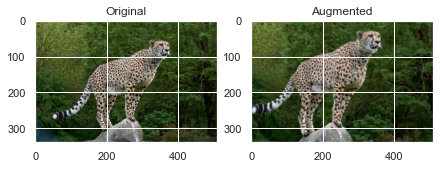

400

In [176]:
all_imgs, all_labels = aug_data(imgs, labels, {2, 101})

## Classification

In [137]:
img_train, img_test, label_train, label_test = train_test_split(all_imgs, all_labels, test_size=0.2, random_state=RANDOM_STATE, stratify=all_labels)

### General Functions

In [138]:
# Evaluation
def run_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)
    y_probs = model.predict_proba(test_data)

    accuracy = accuracy_score(test_labels, yhat)
    print("Accuracy: " + str(accuracy * 100) + "%")

    f_1 = f1_score(test_labels, yhat, average=None)
    print("F_1: " + str(f_1))

    conf_mat = confusion_matrix(test_labels, yhat)
    conf_mat_df = pd.DataFrame(conf_mat, columns=classes, index=classes)
    sns.set(rc={'figure.facecolor':'white'})
    fig = sns.heatmap(conf_mat_df, annot=True, cmap=sns.cm.rocket_r)
    plt.show()

    all_classes = np.unique(test_labels)
    bin_label_test = label_binarize(test_labels, classes=all_classes)

    # from sklearn documentation on roc curves with changed var names
    false_pos_rate = dict()
    true_pos_rate = dict()
    auc_scores = dict()
    for n_class in range(len(all_classes)):
        false_pos_rate[n_class], true_pos_rate[n_class], _ = roc_curve(bin_label_test[:, n_class], y_probs[:, n_class])
        auc_scores[n_class] = auc(false_pos_rate[n_class], true_pos_rate[n_class])
        print("Class: {}, AUC: {}".format(all_classes[n_class], auc_scores[n_class]))
        plt.plot(false_pos_rate[n_class], true_pos_rate[n_class], label=classes[n_class])
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.show()
    


### SIFT

#### Feature Extraction

In [139]:
def process_img(img):
    # img = cv.GaussianBlur(img,(13,13),0) # did not help
    # img = cv.addWeighted(img, 4, cv.blur(img, (30, 30)), -4, 128)
    # _, img = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return img

def extract_with_sift(data, num_des=247, display_idxs={}):
    sift = cv.SIFT_create()
    features = np.array([])
    
    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        bw_img = process_img(bw_img)

        kp, des = sift.detectAndCompute(bw_img, None)
        features = np.vstack((des, features)) if features.size else des
        
        if i in display_idxs:
            img_sift = cv.drawKeypoints(bw_img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_sift)
            plt.show()
    
    return features

#### Bag of Visual Words

Create dictionary by clustering descriptors

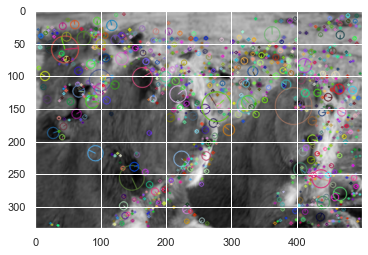

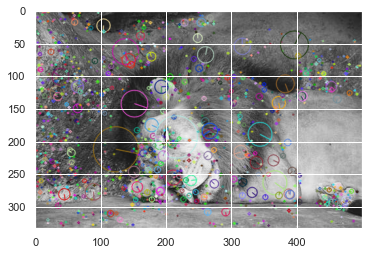

KMeans(n_clusters=100, random_state=50)

In [140]:
all_train_features = extract_with_sift(img_train, display_idxs={0, 5})

# This takes a while
N_CLUSTERS=100
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
kmeans.fit(all_train_features)

Helper functions

In [141]:
# Returns a normalized histogram of the dictionary word frequency
# using the SIFT descriptors of an image
def build_histogram(kmeans_dict, img_des):
    pred = kmeans_dict.predict(img_des)
    hist, _ = np.histogram(pred, bins=N_CLUSTERS)
    # hist_norm = [float(i)/sum(hist) for i in hist] # comment if running with tf_idf
    return hist

# Reflects importance of BOVW features in the image histograms
# See https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more information
def tf_idf_histogram(train_hists, test_hists):
    hists = np.concatenate((np.array(train_hists), np.array(test_hists)), axis=0)
    tf_idf_hists = np.zeros(hists.shape)
    N = hists.shape[0] # total number of images
    n_i = np.sum(hists > 0, axis=0) # number of images where the word w appears (per word)
    
    for hist_id in range(N):
        n_words_i = np.sum(hists[hist_id]) # number of words in the image

        for word_id in range(len(hists[hist_id])):
            n_wi = hists[hist_id, word_id] # count of word w in image i
            tf_idf_hists[hist_id, word_id] = n_wi / n_words_i * np.log(N/n_i[word_id])

        # Normalize hist_id histogram
        tf_idf_hists[hist_id] = [float(i)/sum(tf_idf_hists[hist_id]) for i in tf_idf_hists[hist_id]]
        
    return tf_idf_hists[:len(train_hists)], tf_idf_hists[-len(test_hists):]

Extract BoVW features

In [142]:
kmeans_train_features = []
for img_id in range(len(img_train)):
    if img_train[img_id] is not None:
        d = [img_train[img_id]]
        kmeans_train_features.append(build_histogram(kmeans, extract_with_sift(d)))
    else:
        label_train.pop(img_id)

kmeans_test_features = []       
for img_id in range(len(img_test)):
    if img_test[img_id] is not None:
        d = [img_test[img_id]]
        kmeans_test_features.append(build_histogram(kmeans, extract_with_sift(d)))
    else:
        label_test.pop(img_id)

kmeans_train_features, kmeans_test_features = tf_idf_histogram(kmeans_train_features, kmeans_test_features)

Evaluate with:
    - Random forest classifier
    - Support vector machine

Evaluation with Random Forest Classifier:
Accuracy: 67.5%
F_1: [0.625      0.51428571 0.55172414 0.8        0.88235294]


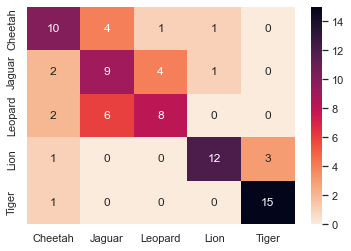

Class: Cheetah, AUC: 0.87548828125
Class: Jaguar, AUC: 0.84375
Class: Leopard, AUC: 0.90771484375
Class: Lion, AUC: 0.96826171875
Class: Tiger, AUC: 0.96923828125


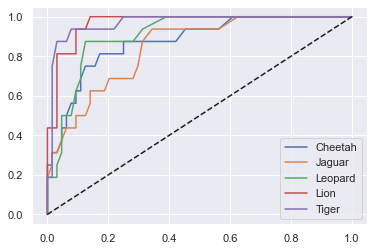


Evaluation with SVM:
Accuracy: 55.00000000000001%
F_1: [0.41666667 0.36842105 0.625      0.53846154 0.75      ]


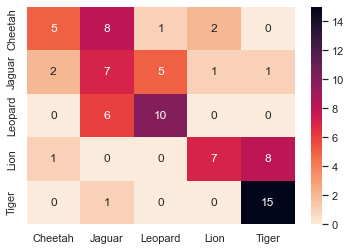

Class: Cheetah, AUC: 0.91796875
Class: Jaguar, AUC: 0.775390625
Class: Leopard, AUC: 0.94140625
Class: Lion, AUC: 0.951171875
Class: Tiger, AUC: 0.9541015625


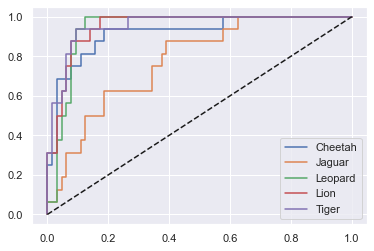

In [161]:
print("Evaluation with Random Forest Classifier:")
run_model(RandomForestClassifier(), kmeans_train_features, label_train, kmeans_test_features, label_test)

print("\nEvaluation with SVM:")
run_model(SVC(probability=True), kmeans_train_features, label_train, kmeans_test_features, label_test)


## Clustering

In [144]:
def clustering_and_vis(model, train_data, test_data, test_labels):
    model.fit(train_data)
    pred = model.predict(test_data)
    silhouette = silhouette_score(test_data, pred)
    mutual_info = mutual_info_score(pred, label_test)
    print("Silhouette: {}, Mutual information: {}".format(silhouette, mutual_info))

    mds = MDS(random_state=RANDOM_STATE, n_components=2)
    X_transform = mds.fit_transform(test_data)

    clusters = np.unique(pred)
    for cluster in clusters:
        r_idx = np.where(np.asarray(pred) == cluster)
        plt.scatter(X_transform[r_idx, 0], X_transform[r_idx, 1], label=cluster)
    plt.legend()
    plt.show()

    for class_ in np.unique(test_labels):
        r_idx = np.where(np.asarray(test_labels) == class_)
        plt.scatter(X_transform[r_idx, 0], X_transform[r_idx, 1], label=class_)
    plt.legend()
    plt.show()
 


Silhouette: 0.23216983262441143, Mutual information: 0.3727870371714095


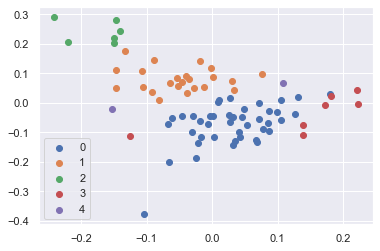

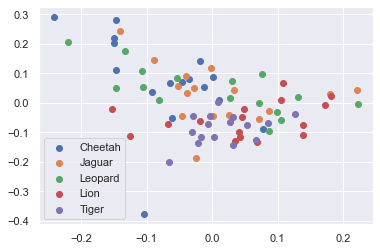

In [145]:

clustering_and_vis(Birch(threshold=0.01, n_clusters=5), kmeans_train_features, kmeans_test_features, label_test)

### FFT

#### Feature Extraction

In [146]:
def fft_spectrum_1D(bw_img):
    f = np.fft.fft2(bw_img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 10*np.log(np.abs(fshift))

    rows, cols = magnitude_spectrum.shape
    magnitude_spectrum_1D = 20*magnitude_spectrum.reshape(rows*cols)

    return magnitude_spectrum.reshape(rows*cols)

def extract_with_fourier(data, display_idxs={}):
    features = []

    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        bw_img = cv.resize(bw_img, (200, 200))
        features.append(fft_spectrum_1D(bw_img))

    return np.array(features)

In [147]:
train_features = extract_with_fourier(img_train, display_idxs={0, 5})
test_features = extract_with_fourier(img_test)

#### Cross Validation

In [148]:
scores = cross_val_score(KNeighborsClassifier(), train_features, label_train, cv=10)
print("KNN Classifier: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

scores = cross_val_score(RandomForestClassifier(), train_features, label_train, cv=10)
print("Random Forest Classifier: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

scores = cross_val_score(SVC(), train_features, label_train, cv=10)
print("SVM: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

KNN Classifier: 34.06% accuracy with a standard deviation of 0.08
Random Forest Classifier: 39.69% accuracy with a standard deviation of 0.07
SVM: 39.38% accuracy with a standard deviation of 0.06


#### Evaluation


Evaluation with KNN:
Accuracy: 36.25%
F_1: [0.34285714 0.32432432 0.14285714 0.62068966 0.38709677]


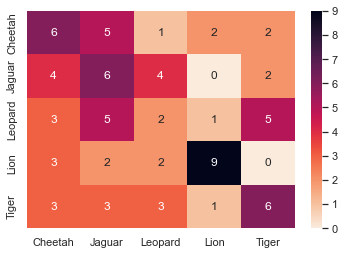

Class: Cheetah, AUC: 0.6015625
Class: Jaguar, AUC: 0.7294921875
Class: Leopard, AUC: 0.5166015625
Class: Lion, AUC: 0.8369140625
Class: Tiger, AUC: 0.755859375


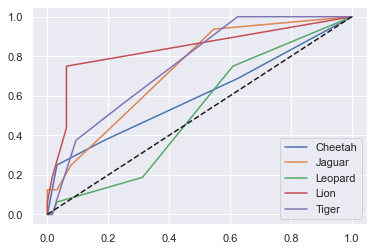

Evaluation with Random Forest Classifier:
Accuracy: 41.25%
F_1: [0.17391304 0.5        0.2        0.625      0.45714286]


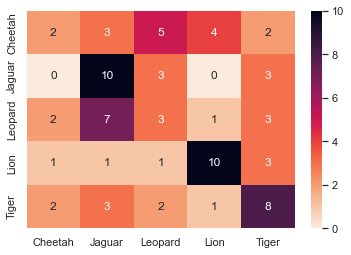

Class: Cheetah, AUC: 0.57666015625
Class: Jaguar, AUC: 0.78955078125
Class: Leopard, AUC: 0.58984375
Class: Lion, AUC: 0.87451171875
Class: Tiger, AUC: 0.7177734375


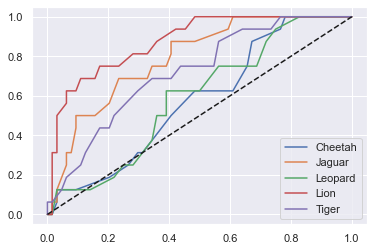


Evaluation with SVM:
Accuracy: 45.0%
F_1: [0.27586207 0.52380952 0.1        0.64705882 0.51428571]


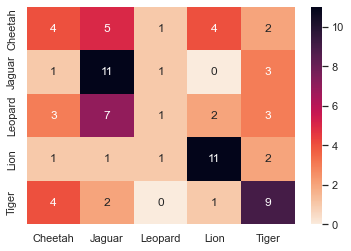

Class: Cheetah, AUC: 0.6025390625
Class: Jaguar, AUC: 0.818359375
Class: Leopard, AUC: 0.59375
Class: Lion, AUC: 0.904296875
Class: Tiger, AUC: 0.78125


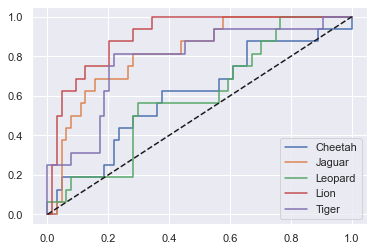

In [149]:
print("\nEvaluation with KNN:")
score = run_model(KNeighborsClassifier(), train_features, label_train, test_features, label_test)

print("Evaluation with Random Forest Classifier:")
score = run_model(RandomForestClassifier(), train_features, label_train, test_features, label_test)

print("\nEvaluation with SVM:")
score = run_model(SVC(probability=True), train_features, label_train, test_features, label_test)

## Image data

In [173]:
def extract_image_data(data):
    features = []

    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        bw_img = cv.GaussianBlur(bw_img, (5,5), cv.BORDER_DEFAULT)
        bw_img = cv.resize(bw_img, (300, 300))
        features.append(bw_img.flatten())
    
    return features

In [174]:
train_features = extract_image_data(img_train)
test_features = extract_image_data(img_test)


Evaluation with KNN:
Accuracy: 28.749999999999996%
F_1: [0.34375    0.11764706 0.28571429 0.35294118 0.11764706]


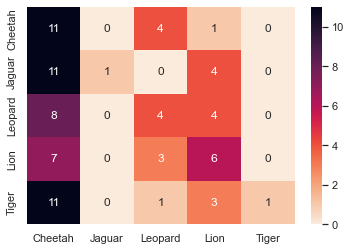

Class: Cheetah, AUC: 0.6416015625
Class: Jaguar, AUC: 0.658203125
Class: Leopard, AUC: 0.669921875
Class: Lion, AUC: 0.63818359375
Class: Tiger, AUC: 0.63427734375


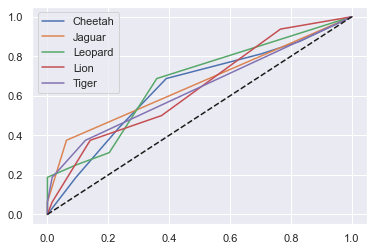

Evaluation with Random Forest Classifier:
Accuracy: 42.5%
F_1: [0.43902439 0.48       0.37037037 0.5        0.34285714]


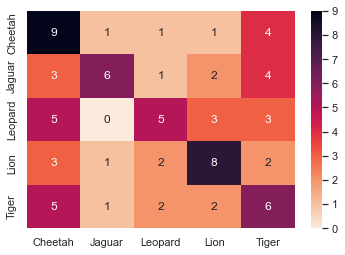

Class: Cheetah, AUC: 0.69580078125
Class: Jaguar, AUC: 0.7568359375
Class: Leopard, AUC: 0.673828125
Class: Lion, AUC: 0.7451171875
Class: Tiger, AUC: 0.71728515625


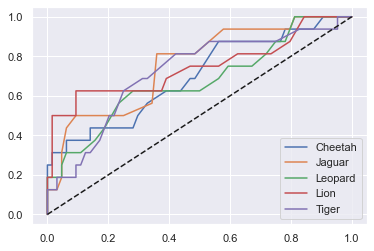


Evaluation with SVM:
Accuracy: 47.5%
F_1: [0.52631579 0.38461538 0.42857143 0.57142857 0.42424242]


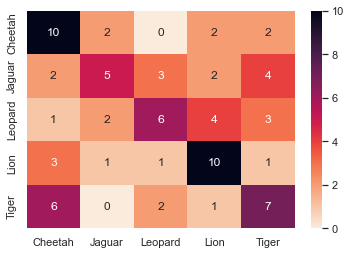

Class: Cheetah, AUC: 0.681640625
Class: Jaguar, AUC: 0.78515625
Class: Leopard, AUC: 0.7236328125
Class: Lion, AUC: 0.8232421875
Class: Tiger, AUC: 0.591796875


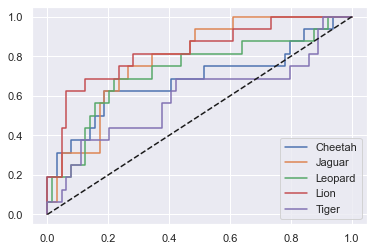


Evalaiton on clustering:


/Users/lisakoopmans/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_birch.py:315: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_


ValueError: Found array with 1 sample(s) (shape=(1, 90000)) while a minimum of 2 is required by AgglomerativeClustering.

In [182]:
print("\nEvaluation with KNN:")
score = run_model(KNeighborsClassifier(), train_features, label_train, test_features, label_test)

print("Evaluation with Random Forest Classifier:")
score = run_model(RandomForestClassifier(), train_features, label_train, test_features, label_test)

print("\nEvaluation with SVM:")
score = run_model(SVC(probability=True), train_features, label_train, test_features, label_test)

# print("\nEvalaiton on clustering:")
# clustering_and_vis(Birch(threshold=0.0001, n_clusters=2), train_features, test_features, label_test)
# it can't find more than 1 cluster